<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/rnn-add-example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Adapted from
# https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:XLA_CPU:0
/job:localhost/replica:0/task:0/device:XLA_GPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


In [7]:
from tensorflow import keras
print(keras.__version__)

2.1.6-tf


### Step 1: Generate sample equations

In [0]:
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.

        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.

        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


In [0]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [10]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
# REVERSE = True
REVERSE = False

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 50000


In [11]:
questions[0]

'83+335 '

In [12]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)


Vectorization...


In [13]:
len(x[0])

7

In [14]:
len(questions[0])

7

In [15]:
questions[0]

'83+335 '

### Input is encoded as one-hot, 7 digits times 12 possibilities

In [16]:
x[0]

array([[False, False, False, False, False, False, False, False, False,
        False,  True, False],
       [False, False, False, False, False,  True, False, False, False,
        False, False, False],
       [False,  True, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False,  True, False, False, False,
        False, False, False],
       [False, False, False, False, False,  True, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False,  True, False,
        False, False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False, False]])

### Same for output, but at most 4 digits

In [17]:
y[0]

array([[False, False, False, False, False, False,  True, False, False,
        False, False, False],
       [False, False, False,  True, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False,  True, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False, False]])

In [18]:
expected[0]

'418 '

In [0]:
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

### Step 2: Training/Validation Split

In [20]:
# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)


### Step 3: Create Model

In [21]:
# input shape: 7 digits, each being 0-9, + or space (12 possibilities)
MAXLEN, len(chars)

(7, 12)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, GRU, SimpleRNN, Dense, RepeatVector

# Try replacing LSTM, GRU, or SimpleRNN.
# RNN = LSTM
RNN = SimpleRNN # should be enough since we do not have long sequences and only local dependencies
# RNN = GRU
HIDDEN_SIZE = 128
BATCH_SIZE = 128

model = Sequential()
# encoder 
model.add(RNN(units=HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))

# latent space
encoding_dim = 32
model.add(Dense(units=encoding_dim, activation='relu', name="encoder"))

# decoder: have 4 temporal outputs one for each of the digits of the results
model.add(RepeatVector(DIGITS + 1))

# return_sequences=True tells it to keep all 4 temporal outputs, not only the final one (we need all four digits for the results)
model.add(RNN(units=HIDDEN_SIZE, return_sequences=True))

model.add(Dense(name='classifier', units=len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               18048     
_________________________________________________________________
encoder (Dense)              (None, 32)                4128      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 32)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 4, 128)            20608     
_________________________________________________________________
classifier (Dense)           (None, 4, 12)             1548      
Total params: 44,332
Trainable params: 44,332
Non-trainable params: 0
_________________________________________________________________


### Before training lets look at sample input and output

In [23]:
# input one-hot
x_val[0]

array([[False, False, False, False, False, False, False, False, False,
        False,  True, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False,  True, False],
       [False,  True, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False,  True, False],
       [False, False, False,  True, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False,  True]])

In [24]:
# output "one-hot" scores
model.predict(np.array([x_val[0]]))

array([[[0.11194286, 0.08703223, 0.04466162, 0.09614258, 0.07991789,
         0.10015881, 0.08792052, 0.0613222 , 0.07658774, 0.07327285,
         0.09509439, 0.08594634],
        [0.0828578 , 0.09545451, 0.04661759, 0.08456481, 0.06100081,
         0.12409856, 0.10386992, 0.05089214, 0.10278594, 0.06949714,
         0.08618999, 0.09217083],
        [0.06040806, 0.0901994 , 0.03527799, 0.09478931, 0.04698731,
         0.16602011, 0.1034363 , 0.04319282, 0.11064598, 0.07751279,
         0.08932592, 0.08220395],
        [0.05838025, 0.0976936 , 0.04050993, 0.11656898, 0.05230108,
         0.15842348, 0.10815699, 0.0403192 , 0.10056987, 0.09268498,
         0.06567447, 0.06871716]]], dtype=float32)

In [25]:
# output decoded by only showing highest score for digit
model.predict_classes(np.array([x_val[0]]))

array([[0, 5, 5, 5]])

### Step 4: Train

In [35]:
%%time

# Train the model each generation and show predictions against the validation
# dataset.

merged_losses = {
    "loss": [],
    "val_loss": []
}

for iteration in range(1, 50):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    iteration_history = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    
    merged_losses["loss"].append(iteration_history.history["loss"])
    merged_losses["val_loss"].append(iteration_history.history["val_loss"])

    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 6s 124us/step - loss: 1.1818 - acc: 0.5528 - val_loss: 1.1146 - val_acc: 0.5736
Q 203+184 T 387  ☒ 414 
Q 964+71  T 1035 ☒ 1044
Q 50+985  T 1035 ☒ 1044
Q 844+486 T 1330 ☒ 1312
Q 584+764 T 1348 ☒ 1446
Q 224+14  T 238  ☒ 237 
Q 81+0    T 81   ☒ 88  
Q 68+194  T 262  ☒ 259 
Q 306+562 T 868  ☒ 774 
Q 652+931 T 1583 ☒ 1406

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 6s 130us/step - loss: 1.0473 - acc: 0.6013 - val_loss: 1.0548 - val_acc: 0.6030
Q 34+303  T 337  ☒ 339 
Q 17+732  T 749  ☒ 740 
Q 3+533   T 536  ☑ 536 
Q 83+446  T 529  ☒ 520 
Q 16+905  T 921  ☒ 901 
Q 90+259  T 349  ☒ 341 
Q 68+299  T 367  ☒ 376 
Q 482+494 T 976  ☒ 1075
Q 371+56  T 427  ☒ 420 
Q 1+653   T 654  ☑ 654 

-------------------

[]

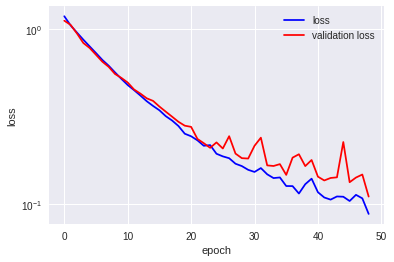

In [41]:
import matplotlib.pyplot as plt

plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')

plt.plot(merged_losses['loss'], 'b')
plt.plot(merged_losses['val_loss'], 'r')

plt.legend(['loss', 'validation loss'])
plt.plot()